# Solve frozen lake with Deep Q-Network

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

Solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using the Deep Q-Network (DQN) method with epsilon-greedy action selection, experience replay and a target network.

Just like the Q-Network, this approach employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) \leftarrow Q(s,a;\theta) + \alpha \delta \ ,
$$

where $\delta = r + \gamma \max_{a'} Q(s',a';\theta') - Q(s,a;\theta)$ is the TD error.

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using sum of squares loss: 

$$
L(\theta) = \sum \delta^2 \ ,
$$

with a batch of transitions $(s,a,r,s')$ sampled from an experience replay memory. 

Notice how the DQN implementation uses a different set of parameters, $\theta'$, to compute the target value. This is the target network parameters which are a delayed copy of $\theta$.
The implementation below uses "soft" target updates rather than copying the weights periodically:

$$
\theta' \leftarrow \tau \, \theta + (1-\tau) \, \theta' \ ,
$$

with $\tau \ll 1$.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

In [7]:
# initialize environment
env = gym.make('FrozenLake-v0')

In [8]:
# show initial state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [9]:
class DQN(nn.Module):
    """Deep Q-network with target network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(DQN, self).__init__()
        # network
        self.out = nn.Linear(n_inputs, n_outputs)
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
    
    def forward(self, x):
        return self.out(x)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [10]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

In [11]:
# one-hot encoder for the states
def one_hot(i, l):
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [12]:
# train Deep Q-network

num_episodes = 1000
episode_limit = 100
batch_size = 64
learning_rate = 0.005
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
replay_memory_capacity = 10000
prefill_memory = True
val_freq = 100 # validation frequency

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

# initialize DQN and replay memory
policy_dqn = DQN(n_inputs, n_outputs, learning_rate)
target_dqn = DQN(n_inputs, n_outputs, learning_rate)
target_dqn.load_state_dict(policy_dqn.state_dict())

replay_memory = ReplayMemory(replay_memory_capacity)

# prefill replay memory with random actions
if prefill_memory:
    print('prefill replay memory')
    s = env.reset()
    while replay_memory.count() < replay_memory_capacity:
        a = env.action_space.sample()
        s1, r, d, _ = env.step(a)
        replay_memory.add(s, a, r, s1, d)
        s = s1 if not d else env.reset()
        
# training loop
try:
    print('start training')
    epsilon = 1.0
    rewards, lengths, losses, epsilons = [], [], [], []
    for i in range(num_episodes):
        # init new episode
        s, ep_reward, ep_loss = env.reset(), 0, 0
        for j in range(episode_limit):
            # select action with epsilon-greedy strategy
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    a = policy_dqn(torch.from_numpy(one_hot([s], n_inputs)).float()).argmax().item()
            # perform action
            s1, r, d, _ = env.step(a)
            # store experience in replay memory
            replay_memory.add(s, a, r, s1, d)
            # batch update
            if replay_memory.count() >= batch_size:
                # sample batch from replay memory
                batch = np.array(replay_memory.sample(batch_size), dtype=int)
                ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
                # do forward pass of batch
                policy_dqn.optimizer.zero_grad()
                Q = policy_dqn(torch.from_numpy(one_hot(ss, n_inputs)).float())
                # use target network to compute target Q-values
                with torch.no_grad():
                    # TODO: use target net
                    Q1 = target_dqn(torch.from_numpy(one_hot(ss1, n_inputs)).float())
                # compute target for each sampled experience
                q_targets = Q.clone()
                for k in range(batch_size):
                    q_targets[k, aa[k]] = rr[k] + gamma * Q1[k].max().item() * (not dd[k])
                # update network weights
                loss = policy_dqn.loss(Q, q_targets)
                loss.backward()
                policy_dqn.optimizer.step()
                # update target network parameters from policy network parameters
                target_dqn.update_params(policy_dqn.state_dict(), tau)
            else:
                loss = 0
            # bookkeeping
            s = s1
            ep_reward += r
            ep_loss += loss.item()
            if d: break
        # bookkeeping
        epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: print('%5d mean training reward: %5.2f' % (i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

prefill replay memory
start training
  100 mean training reward:  0.03
  200 mean training reward:  0.03
  300 mean training reward:  0.09
  400 mean training reward:  0.24
  500 mean training reward:  0.40
  600 mean training reward:  0.53
  700 mean training reward:  0.68
  800 mean training reward:  0.63
  900 mean training reward:  0.72
 1000 mean training reward:  0.72
done


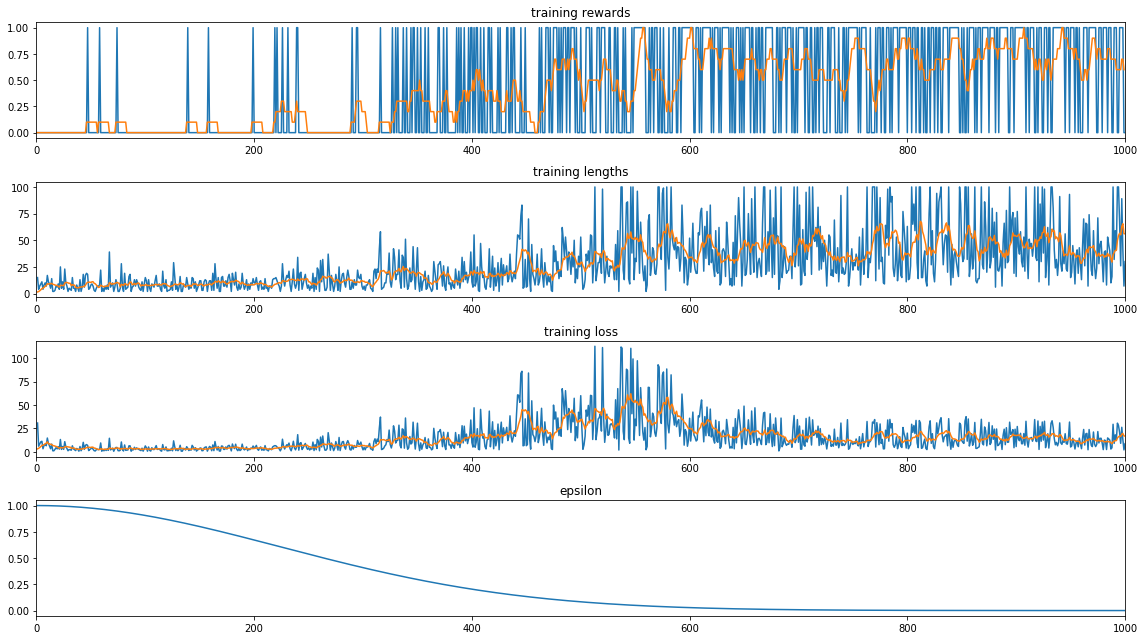

In [13]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()

After the [initial success of DQN](https://www.nature.com/articles/nature14236), the method as been extended in a number of ways. Here are some of the more successfull improvements:

* [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461)
* [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)
* [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581)
